# 3. EDA

![picture](img/picture9.png)
The EDA notebook will cover the following:

#### Content
* Spark Summarised Stats
* Pie Chart
* Length of Text
* Word Length
* Bigrams and Trigrams
* Semantic Textual Similarity using SparkNLP
* Topic Modelling with BERTopic

In [1]:
%_do_not_call_change_endpoint --username  --password --server https://lighter-staging.vbrani.aisingapore.net/lighter/api  

In [ ]:
%%configure -f
{"conf": {
        "spark.sql.warehouse.dir" : "s3a://dataops-example/justin",
        "spark.hadoop.fs.s3a.access.key":"",
        "spark.hadoop.fs.s3a.secret.key": "",
        "spark.serializer": "org.apache.spark.serializer.KryoSerializer", 
        "spark.kryoserializer.buffer.max": "2000M",
        "spark.driver.maxResultSize": "0",
        "spark.kubernetes.container.image": "justinljg/dep:1.08",
        "spark.kubernetes.container.image.pullPolicy" : "Always",
        "spark.jsl.settings.pretrained.cache_folder": "/opt/spark/work-dir",
        "spark.kubernetes.driver.volumes.persistentVolumeClaim.lighter-sparknlptest-pvc.options.claimName": "lighter-sparknlptest-pvc",
        "spark.kubernetes.driver.volumes.persistentVolumeClaim.lighter-sparknlptest-pvc.mount.path": "/opt/spark/work-dir",
        "spark.kubernetes.executor.volumes.persistentVolumeClaim.lighter-sparknlptest-pvc.options.claimName": "lighter-sparknlptest-pvc",
        "spark.kubernetes.executor.volumes.persistentVolumeClaim.lighter-sparknlptest-pvc.mount.path": "/opt/spark/work-dir",
        "spark.jsl.settings.annotator.log_folder": "/opt/spark/work-dir/logs"
    },
 "executorMemory": "6G",
 "executorCores": 2,
 "driverMemory": "16G",
 "driverCores": 1
}

In [ ]:
import json
import os

import numpy as np
import pandas as pd
import pyspark
import sparknlp

from delta import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import StopWordsRemover
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, lower, udf
from pyspark.sql.types import ArrayType, DoubleType, StructType, StructField, StringType, IntegerType
import pyspark.sql.functions as F
from sparknlp.annotator import *
from sparknlp.base import *
from sparknlp.pretrained import PretrainedPipeline

from bertopic import BERTopic
from hdbscan import HDBSCAN
from umap import UMAP

from transformers.pipelines import pipeline


In [4]:
%%local

import matplotlib.pyplot as plt
import nltk
import pandas as pd
from collections import defaultdict, Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import ImageColorGenerator, STOPWORDS, WordCloud

In [5]:
%%sql

USE SparkNLP

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

## Spark Summarised Stats

This shows the count, mean stddev, min and max of the selected columns

This portion reads the table, selects the columns and show the description of the selected columns. The count is then selected to show show the individual word counts.

[Example (.read.table), ](https://sparkbyexamples.com/spark/spark-spark-table-vs-spark-read-table/)[Documentation (.describe)](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.describe.html) 

In [6]:
df = spark.read.table("greview_viz")
df.describe(['text_length','rating']).show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+-----------------+
|summary|text_length       |rating           |
+-------+------------------+-----------------+
|count  |436317            |436317           |
|mean   |92.52852169408939 |4.333832970065342|
|stddev |126.86992675412577|1.087607526896818|
|min    |1                 |1                |
|max    |4095              |5                |
+-------+------------------+-----------------+

In [7]:
spark.sql("SELECT COUNT(*) FROM greview_viz_word;").show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+
|count(1)|
+--------+
|4189338 |
+--------+

In [8]:
df_cloud = spark.read.table("greview_viz_word")
df_cloud.show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+
|word    |
+--------+
|placed  |
|order   |
|grubhub |
|530     |
|pm      |
|someone |
|door    |
|food    |
|550     |
|pm      |
|magic   |
|say     |
|feat    |
|nothing |
|wong    |
|order   |
|either  |
|awesome |
|food    |
|friendly|
+--------+
only showing top 20 rows

Sparkmagic is unable to show visualisations in the pyspark kernel. Thus, the datafame has to be brought to a local python context. This portion brings a pandas dataframe to a local context. Something to take note of is that sparkmagic samples the dataframe up to 2500 rows.

```df_word``` is the variable given to the data frame. This dataframe is formed through a select sql query. 
To see the other functions provided by sparkmagic you can run ```%%help``` in a cell to see it. 

![picture](img/picture20.png)

In [9]:
%%sql -o df_word -q

SELECT * FROM greview_viz_word

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

This portion of code uses the Python WordCloud library to generate a word cloud based on the frequency of words in the input data. First, a WordCloud object is created with specified properties for width, height, and background color. Then, the code calculates the frequency of each word in the input data using a dictionary. The generate_from_frequencies() method is used to generate the word cloud from the frequency dictionary. Finally, the word cloud is displayed using the matplotlib.pyplot library, with the axis turned off and the image shown. The resulting word cloud visually represents the frequency of words in the input data, with more frequent words appearing larger in size.

[Documentation (wordcloud), ](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html)[Documentation (value_counts), ](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html)[Documentation (to_dict)](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_dict.html)

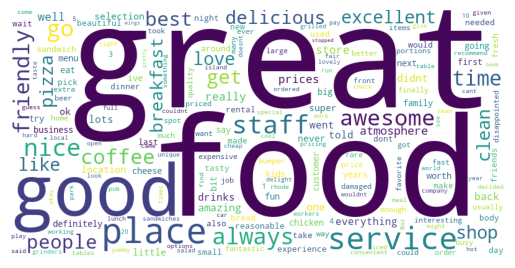

In [10]:
%%local

# create a WordCloud object with desired properties
wordcloud = WordCloud(width=800, height=400, background_color="white")

word_freq = df_word['word'].value_counts().to_dict()

# generate the wordcloud from the dictionary of word frequencies
wordcloud.generate_from_frequencies(word_freq)

# display the wordcloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [11]:
%%spark -o df

df = spark.read.table("greview_viz")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

This portion plots a pie chart based on the ratings column.

[Documentation (plot)](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)

<Axes: ylabel='rating'>

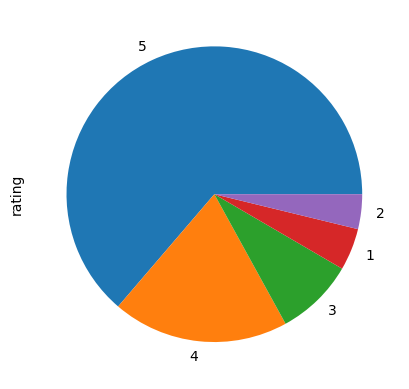

In [12]:
%%local

df['rating'].value_counts().plot(kind='pie')

In [13]:
df.show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------+-------------------------------------+-------------+------+-----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|index|text                

This portion sets the list of colours for visualisations.

In [14]:
%%local
color_list = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00"]

In [15]:
%%spark -o df

df = spark.read.table("greview_viz")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

This portion runs a for loop to plot the text lengths for each rating respectively. The dataframe is filtered, then a list is created and the iteration number is used to define the color from color list. This is all run in a local context. After this portion, an overall visualisation was outputted in the cell after.

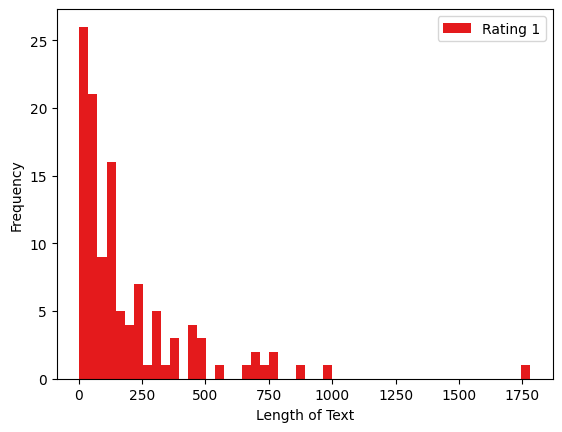

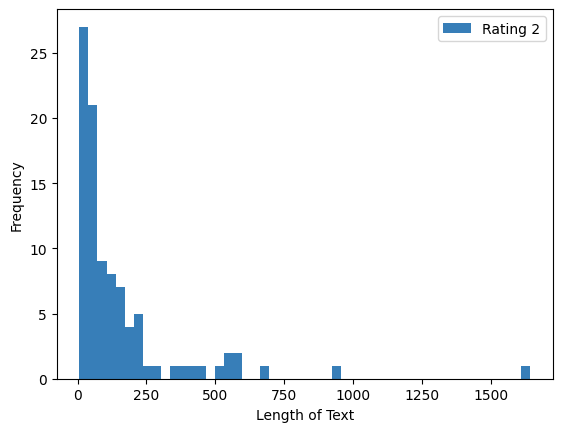

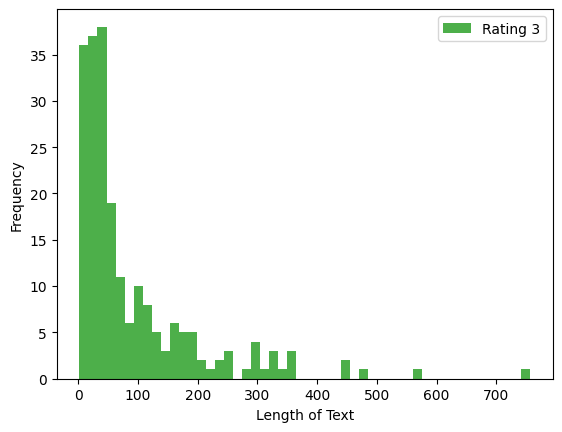

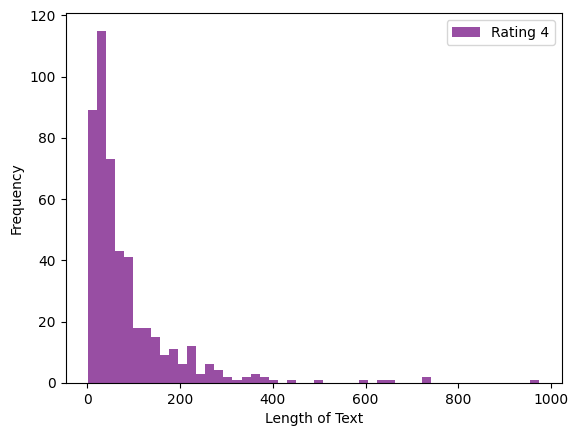

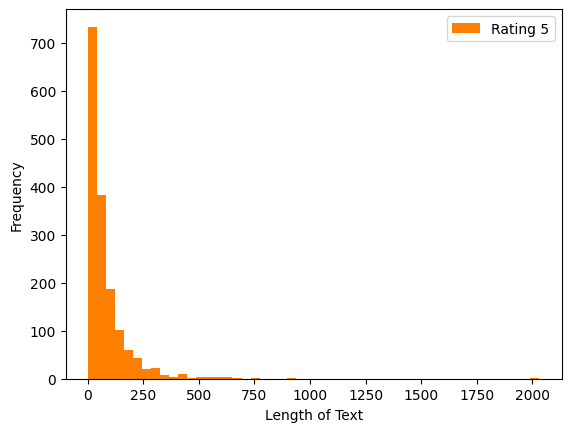

In [16]:
%%local

for i in range(1, 6):
    # Filter the DataFrame to select only the rows with the current rating
    df_rating = df[df['rating'] == i]

    # Calculate the length of the headline text for the current rating
    lengths_list = df_rating['text_length'].tolist()

    # Define custom colors for each rating
    color= color_list[i-1]
        
    # Plot histogram using matplotlib
    plt.hist(lengths_list, bins=50, label="Rating {}".format(i), color=color)
    plt.xlabel("Length of Text")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


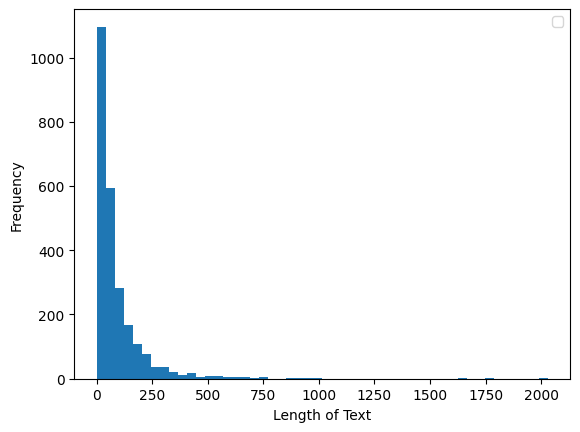

In [17]:
%%local

# Calculate the length of the headline text for the current rating
lengths_list = df['text_length'].tolist()

plt.hist(lengths_list, bins=50)
plt.xlabel("Length of Text")
plt.ylabel("Frequency")
plt.legend()
plt.show()

This portion does the same thing but as length of text but has 3 main differences. It splits the text in the column text, applies a lambda function to calculate the word length and use another lambda function to output the mean word length.

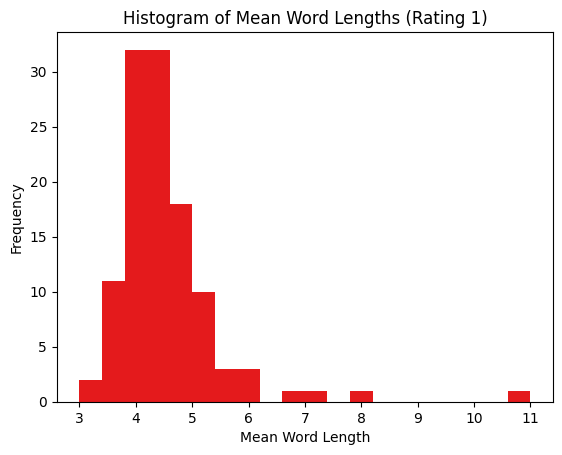

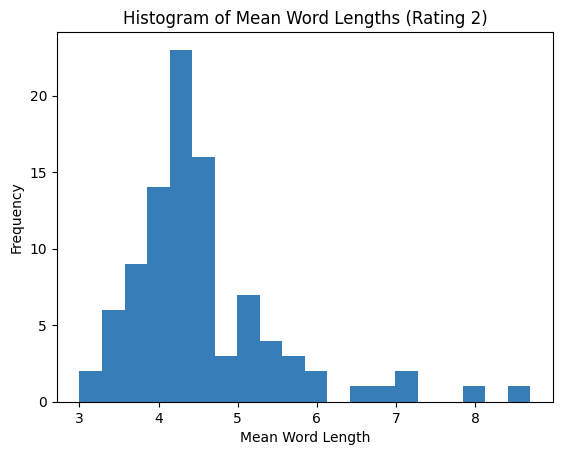

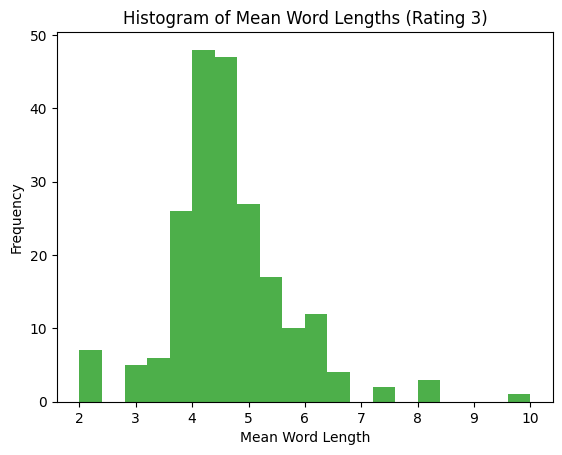

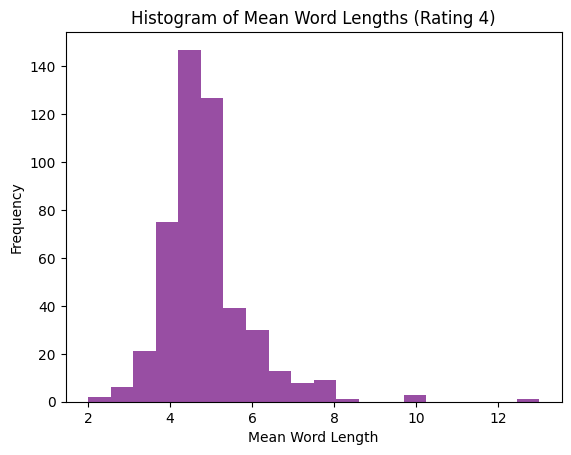

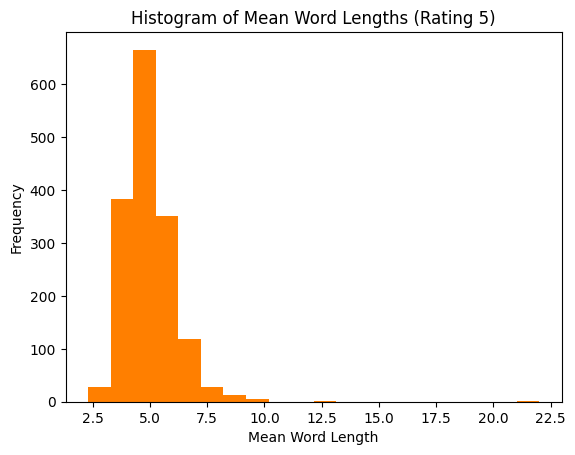

In [18]:
%%local

for rating in range(1, 6):
    
    # Define custom colors for each rating
    color= color_list[rating-1]

    # Filter the DataFrame to select only the rows with the current rating
    df_rating = df[df['rating'] == rating]

    # Split the headline_text column into a list of words
    split_text = df_rating['text'].str.split()

    # Calculate the length of each word in the split_text column
    word_lengths = split_text.apply(lambda x: [len(word) for word in x])

    # Calculate the mean of a list of numbers
    mean_word_lengths = word_lengths.apply(lambda x: round(sum(x) / len(x), 1) if len(x) > 0 else 0)


    # Plot the histogram using matplotlib
    plt.hist(mean_word_lengths, bins=20, color=color)
    plt.title('Histogram of Mean Word Lengths (Rating {})'.format(rating))
    plt.xlabel('Mean Word Length')
    plt.ylabel('Frequency')
    plt.show()


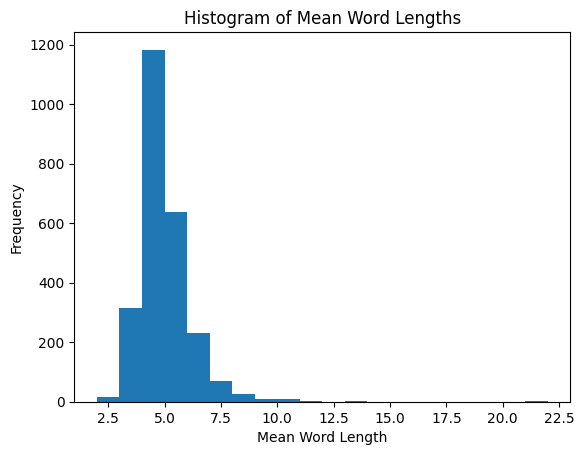

In [19]:
%%local

# Split the headline_text column into a list of words
split_text = df['text'].str.split()

# Calculate the length of each word in the split_text column
word_lengths = split_text.apply(lambda x: [len(word) for word in x])

# Calculate the mean of a list of numbers
mean_word_lengths = word_lengths.apply(lambda x: round(sum(x) / len(x), 1) if len(x) > 0 else 0)


# Plot the histogram using matplotlib
plt.hist(mean_word_lengths, bins=20)
plt.title('Histogram of Mean Word Lengths')
plt.xlabel('Mean Word Length')
plt.ylabel('Frequency')
plt.show()

In [20]:
%%local
# load NLTK stopwords
nltk.download('stopwords',download_dir ="/home/jovyan/work")
nltk.data.path.append("/home/jovyan/work")
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/work...
[nltk_data]   Package stopwords is already up-to-date!


This portion plots the top words and stopwords.

```words_df``` is the dataframe that is all lowered cased split into individual words. 

For the regex,
* ```\s``` is a special character in regular expressions that represents any whitespace character, such as spaces, tabs, or line breaks.
* ```+``` is a quantifier in regular expressions that specifies "one or more" occurrences of the preceding element.
```\s+``` means that the pattern should match one or more consecutive whitespace characters.

The dataframe words is then outputs into a list that forms the corpus. The words are then put into a dictionary and the top words & stopwords are visualised.

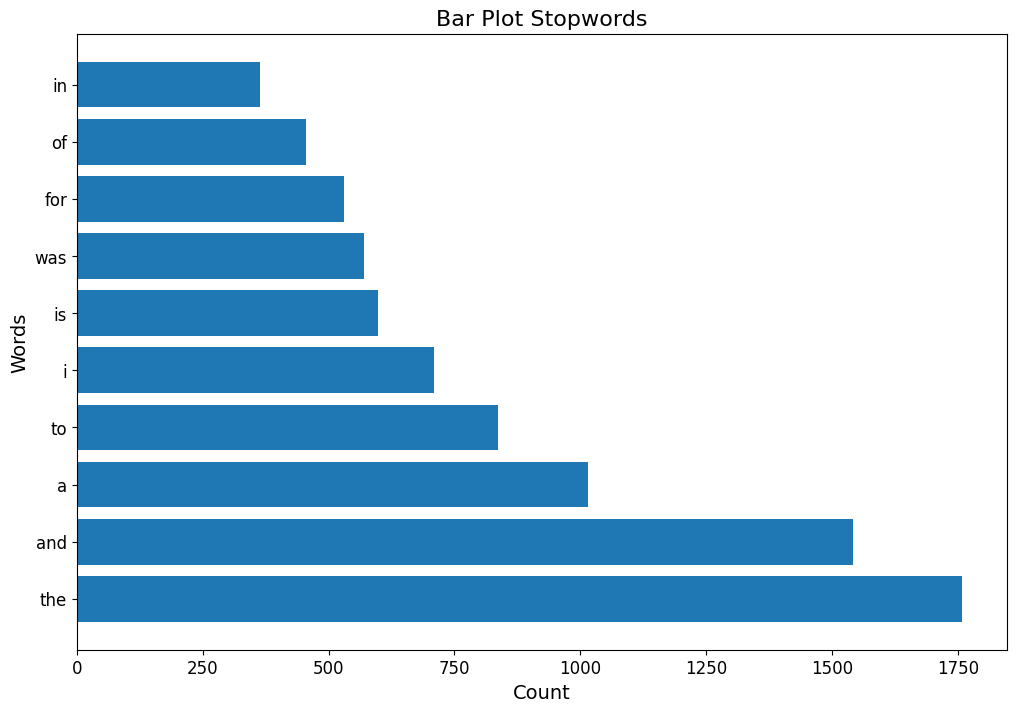

<Figure size 1000x600 with 0 Axes>

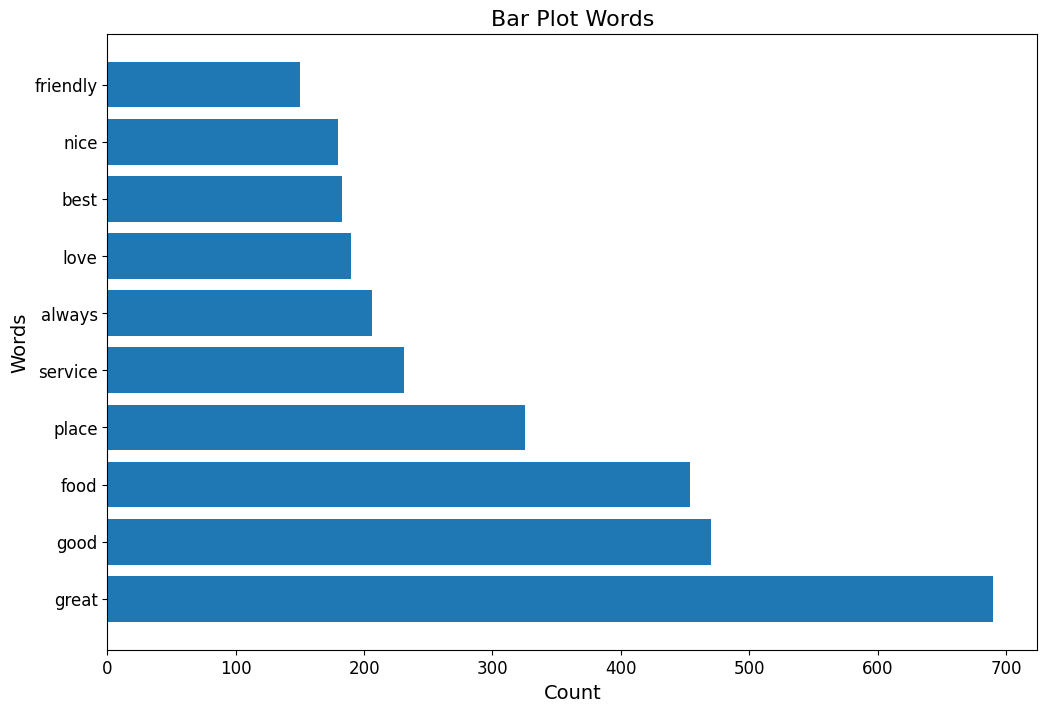

<Figure size 1000x600 with 0 Axes>

In [21]:
%%local
# Split the text column to create a new DataFrame with the words
words_df = df['text'].str.lower().str.split("\s+").rename("words")

# Create a list of all the words
corpus = [word for row in words_df for word in row]

# Count occurrences of each stop word in the corpus
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)

fig, ax = plt.subplots(figsize=(12, 8))  # Create a figure and axes objects

# Create the bar plot
ax.barh(x, y)

# Set the labels and title
ax.set_xlabel('Count', fontsize=14)
ax.set_ylabel('Words', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_title('Bar Plot Stopwords', fontsize=16)
plt.figure(figsize=(10,6))
plt.tight_layout()  # Adjust the layout

plt.show()  # Display the plot

plt.show()

x,y =[],[]

dic2 = defaultdict(int)
for word in corpus:
    if word not in stop:
        dic2[word] += 1

top=sorted(dic2.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)

fig1, ax1 = plt.subplots(figsize=(12, 8))  # Create a figure and axes objects

# Create the bar plot
ax1.barh(x, y)

# Set the labels and title
ax1.set_xlabel('Count', fontsize=14)
ax1.set_ylabel('Words', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax1.set_title('Bar Plot Words', fontsize=16)
plt.figure(figsize=(10,6))
plt.tight_layout()  # Adjust the layout

plt.show()  # Display the plot

A function to get the top N grams is defined here. The get_top_ngram function is designed to extract the top N-grams from a given corpus. It utilizes the CountVectorizer module from scikit-learn to create a bag of words representation. The words are then aggregated, sorted based on their frequency, and the top 10 words are returned.

In [22]:
%%local

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(token_pattern=r"(?u)\b\w+\b", 
                stop_words=None, ngram_range=(n,n), analyzer='word').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

Similarly, it runs a for loop to output the bigrams for each ratings. After that an overall bigrams is produced. The trigrams runs on the same code with only the n variable for the ```get_top_ngram``` function being changed rom 2 to 3.
```

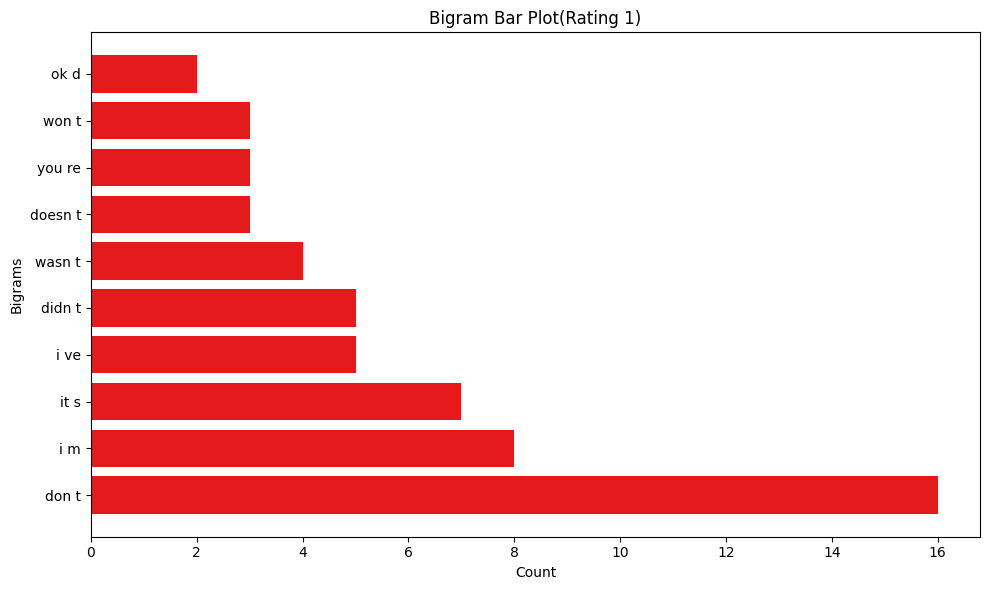

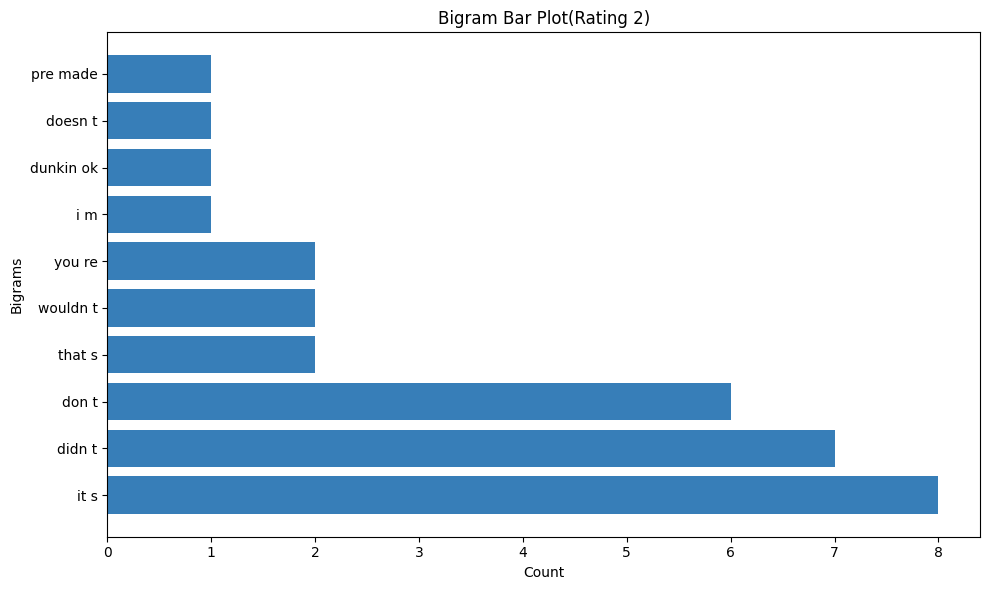

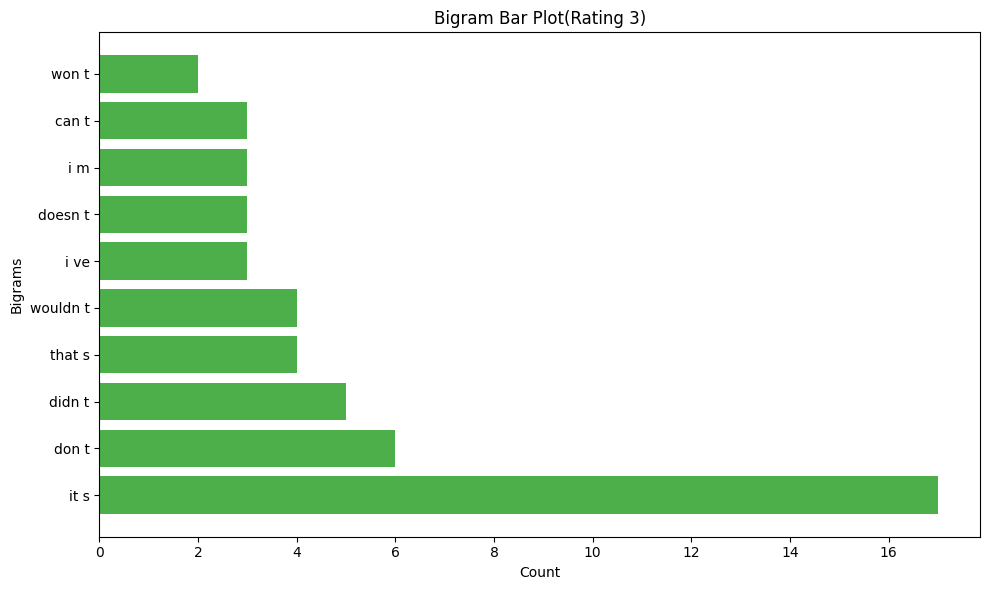

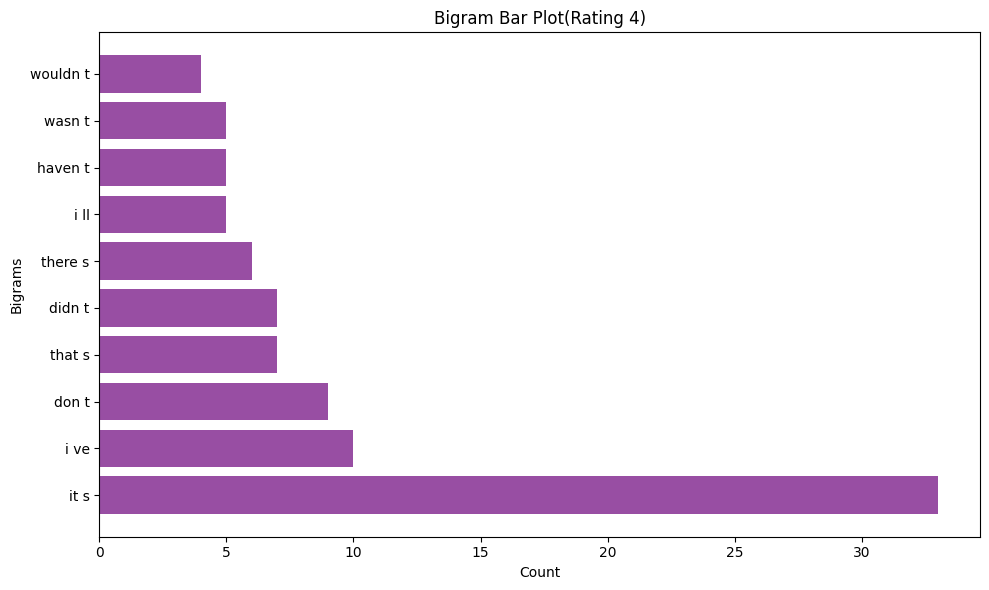

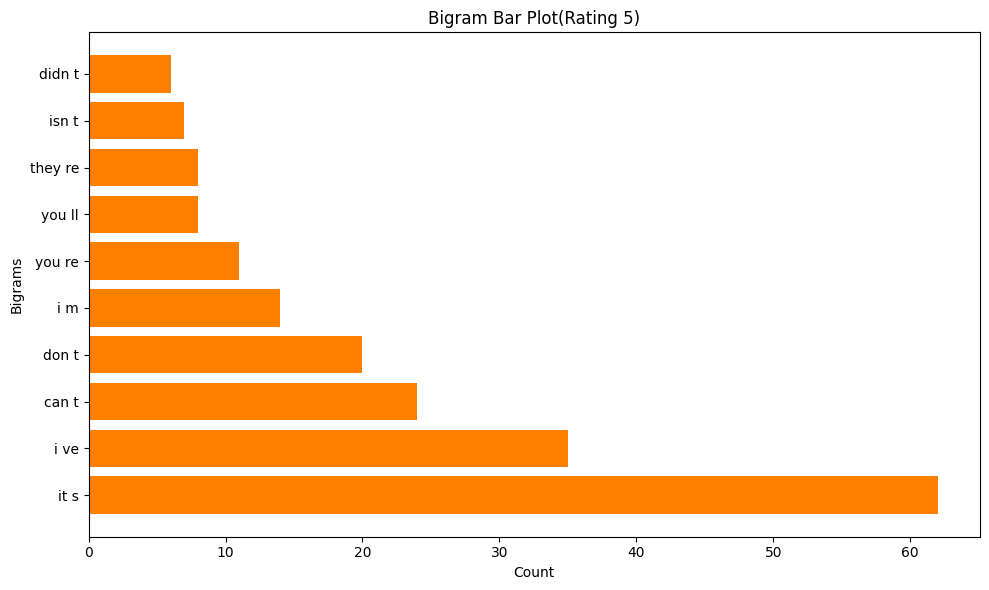

In [23]:
%%local

for rating in range(1, 6):
    
    # Define custom colors for each rating
    color= color_list[rating-1]

    df_rating = df[df['rating'] == rating]

    # Split the text column to create a new DataFrame with the words
    words_df = df_rating['text'].str.lower().str.split("\s+").rename("words")

    # Create a list of all the words
    corpus = [word for row in words_df for word in row]

    # Get the top 10 bigrams from the corpus
    top_n_bigrams= get_top_ngram(corpus,2)
    x, y = map(list, zip(*top_n_bigrams))

    # Create a figure and axes objects
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create the horizontal bar plot
    ax.barh(range(len(x)), y,color=color)

    # Set the y-axis ticks and labels
    ax.set_yticks(range(len(x)))
    ax.set_yticklabels(x)

    # Set the labels and title
    ax.set_xlabel('Count')
    ax.set_ylabel('Bigrams')
    ax.set_title(f'Bigram Bar Plot(Rating {rating})')

    plt.tight_layout()
    plt.show()

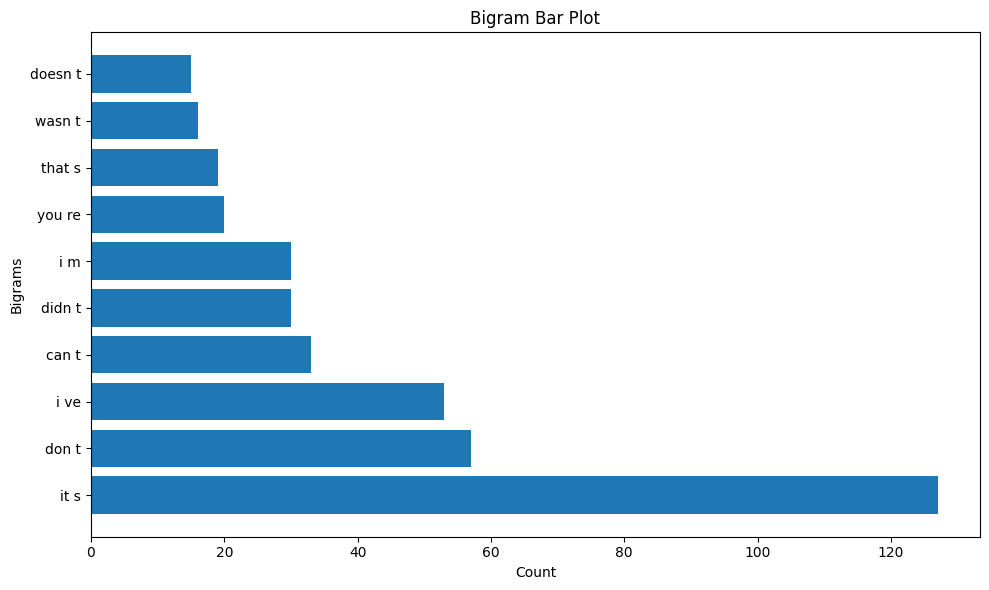

In [24]:
%%local
# Split the text column to create a new DataFrame with the words
words_df = df['text'].str.lower().str.split("\s+").rename("words")

# Create a list of all the words
corpus = [word for row in words_df for word in row]

# Get the top 10 bigrams from the corpus
top_n_bigrams = get_top_ngram(corpus, 2)
x, y = map(list, zip(*top_n_bigrams))

# Create a figure and axes objects
fig, ax = plt.subplots(figsize=(10, 6))

# Create the horizontal bar plot
ax.barh(range(len(x)), y)

# Set the y-axis ticks and labels
ax.set_yticks(range(len(x)))
ax.set_yticklabels(x)

# Set the labels and title
ax.set_xlabel('Count')
ax.set_ylabel('Bigrams')
ax.set_title('Bigram Bar Plot')

plt.tight_layout()
plt.show()

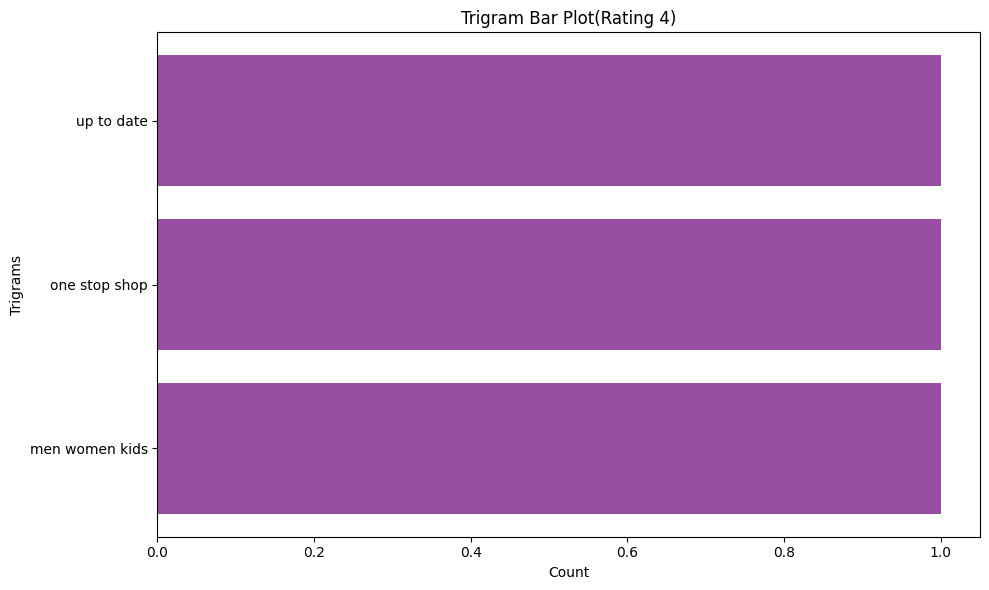

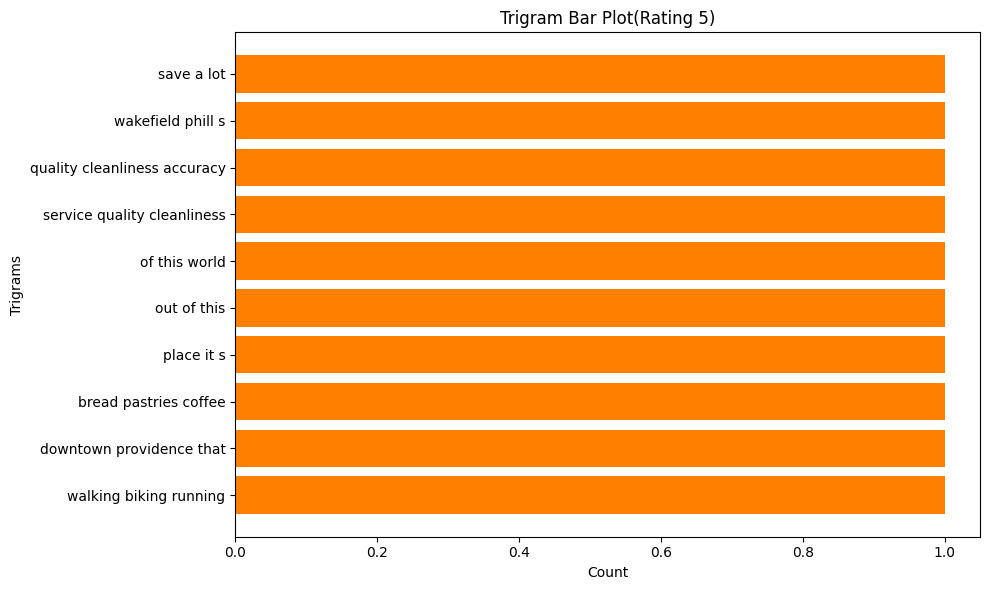

In [25]:
%%local

for rating in range(4, 6):
    
    color= color_list[rating-1]

    df_rating = df[df['rating'] == rating]
    
    # Split the text column to create a new DataFrame with the words
    words_df = df_rating['text'].str.lower().str.split("\s+").rename("words")

    # Create a list of all the words
    corpus = [word for row in words_df for word in row]

    # Get the top 10 bigrams from the corpus
    top_n_bigrams = get_top_ngram(corpus, 3)
    x, y = map(list, zip(*top_n_bigrams))

    # Create a figure and axes objects
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create the horizontal bar plot
    ax.barh(range(len(x)), y,color=color)

    # Set the y-axis ticks and labels
    ax.set_yticks(range(len(x)))
    ax.set_yticklabels(x)

    # Set the labels and title
    ax.set_xlabel('Count')
    ax.set_ylabel('Trigrams')
    ax.set_title(f'Trigram Bar Plot(Rating {rating})')

    plt.tight_layout()
    plt.show()

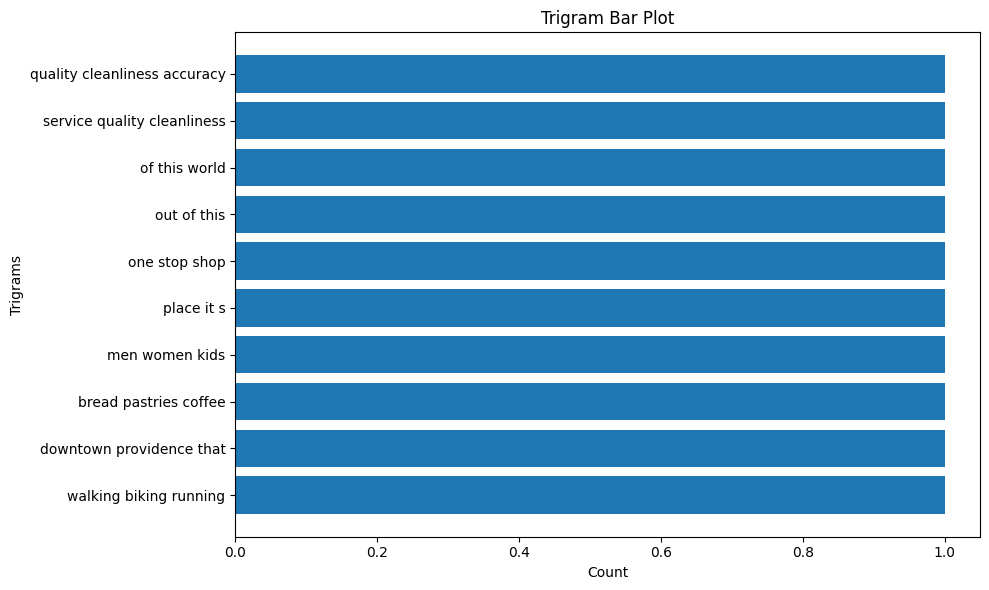

In [26]:
%%local
# Split the text column to create a new DataFrame with the words
words_df = df['text'].str.lower().str.split("\s+").rename("words")

# Create a list of all the words
corpus = [word for row in words_df for word in row]

# Get the top 10 bigrams from the corpus
top_n_bigrams = get_top_ngram(corpus, 3)
x, y = map(list, zip(*top_n_bigrams))

# Create a figure and axes objects
fig, ax = plt.subplots(figsize=(10, 6))

# Create the horizontal bar plot
ax.barh(range(len(x)), y)

# Set the y-axis ticks and labels
ax.set_yticks(range(len(x)))
ax.set_yticklabels(x)

# Set the labels and title
ax.set_xlabel('Count')
ax.set_ylabel('Trigrams')
ax.set_title('Trigram Bar Plot')

plt.tight_layout()
plt.show()

#### Spark NLP Library

![picture](img/picture19.png)

John Snow Labs Spark NLP is a powerful natural language processing (NLP) library that enhances the capabilities of Apache Spark, an open-source big data processing framework. It offers a wide array of NLP functionalities, including text processing, named entity recognition, part-of-speech tagging, sentiment analysis, spell checking, document classification, and more.

Spark NLP leverages the distributed computing capabilities of Apache Spark, enabling efficient and parallel processing of large-scale NLP tasks. It provides ready-to-use pre-trained models for various NLP tasks, as well as a versatile pipeline API for creating customized NLP workflows.

The library supports multiple languages, making it suitable for multilingual NLP applications. It also includes diverse embeddings and word vectors, such as Word2Vec and BERT, for advanced text representation and feature extraction.

John Snow Labs, the organization behind Spark NLP, is committed to the ongoing development and maintenance of the library. They regularly provide updates, bug fixes, and support to their users. Additionally, they offer both open-source and commercial versions of Spark NLP, with the commercial version featuring additional enterprise functionalities and support.


#### Standard Spark NLP pipeline overview
The standard Spark NLP pipeline consists of the following document assembler, tokenizer, embeddings, annotator and finisher. 

* document assembler : gets raw data annotated.
* tokenizer : tokenizes the data
* embeddings : get the required embeddings for annotator
* annotator : the required output e.g. classify to labels
* finisher : gets the required output to desired state\


#### Sentence Similarity
In this case for sentence similarity, document assembler, tokenizer and a pretrained model for a universal sentence encoder for tf hub is used to output the similarity between the texts. The pretrained base model is used so the pipeline is fitted on a empty dataframe.

In [27]:
MODEL_NAME = "tfhub_use"

# Transforms the input text into a document usable by the SparkNLP pipeline.
document_assembler = DocumentAssembler()
document_assembler.setInputCol('text')
document_assembler.setOutputCol('document')

# Separates the text into individual tokens (words and punctuation).
tokenizer = Tokenizer()
tokenizer.setInputCols(['document'])
tokenizer.setOutputCol('token')

# Encodes the text as a single vector representing semantic features.
sentence_encoder = UniversalSentenceEncoder.pretrained(name=MODEL_NAME)
sentence_encoder.setInputCols(['document'])
sentence_encoder.setOutputCol('sentence_embeddings')

nlp_pipeline = Pipeline(stages=[
    document_assembler, 
    tokenizer,
    sentence_encoder
])

# Fit the model to an empty data frame so it can be used on inputs.
empty_df = spark.createDataFrame([['']]).toDF('text')
pipeline_model = nlp_pipeline.fit(empty_df)
light_pipeline = LightPipeline(pipeline_model)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]

In [28]:
df2 = df.limit(20)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
def get_similarity(df):
    result = light_pipeline.transform(df)
    embeddings = []
    for r in result.collect():
        embeddings.append(r.sentence_embeddings[0].embeddings)
    embeddings_matrix = np.array(embeddings)
    return np.matmul(embeddings_matrix, embeddings_matrix.transpose())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
ss_mat = get_similarity(df2)
# Convert the NumPy array to a list of tuples
data = [(i,) for i in ss_mat.tolist()]

# Create a DataFrame from the list of tuples
df_similarity = spark.createDataFrame(data, ["similarity"])


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
ss_mat

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array([[ 0.99999991,  0.40556599,  0.42475378,  0.49354024, -0.01382269,
         0.53211149,  0.26842684,  0.16798863,  0.11432802,  0.47910778,
         0.44388662,  0.11113984,  0.36513712,  0.30533646,  0.04946556,
         0.36724388,  0.59555546,  0.45635414,  0.56680713,  0.24363079],
       [ 0.40556599,  1.00000012,  0.74259079,  0.48738532,  0.1619727 ,
         0.52273465,  0.46176202,  0.61377972,  0.35461268,  0.5440617 ,
         0.41754255,  0.36287824,  0.55792288,  0.27533914,  0.49151571,
         0.62848028,  0.56522204,  0.61778208,  0.74315591,  0.43536726],
       [ 0.42475378,  0.74259079,  1.00000003,  0.65561279,  0.10206647,
         0.61870222,  0.46347206,  0.50688947,  0.22456205,  0.58639041,
         0.45088305,  0.32723944,  0.62137138,  0.33895023,  0.3186831 ,
         0.78575888,  0.5682412 ,  0.74078868,  0.7108744 ,  0.53475087],
       [ 0.49354024,  0.48738532,  0.65561279,  1.00000007,  0.09165813,
         0.6818302 ,  0.36411967,  0.2903324 ,  

In [32]:
%%spark -o df_similarity

df_similarity

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[similarity: array<double>]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
%%spark -o df2

df2

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[index: bigint, text: string, Cleaned_text: string, userid: double, gmap_id: string, time: bigint, rating: int, text_length: int, preprocessed_text: array<string>]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Transferring to Local Context
A function is then created to get the matrix of the sentence similarity output. It is then converted to a dataframe to be port over to the local context.

In [34]:
%%local
import numpy as np
# Original array
matrix = df_similarity['similarity'].to_numpy()

# Convert elements to float individually
new_matrix = np.array([[float(val) for val in sublist] for sublist in matrix])

#### Plotting
It is then plotted by matplotlib and a function to produce the heat map is defined.

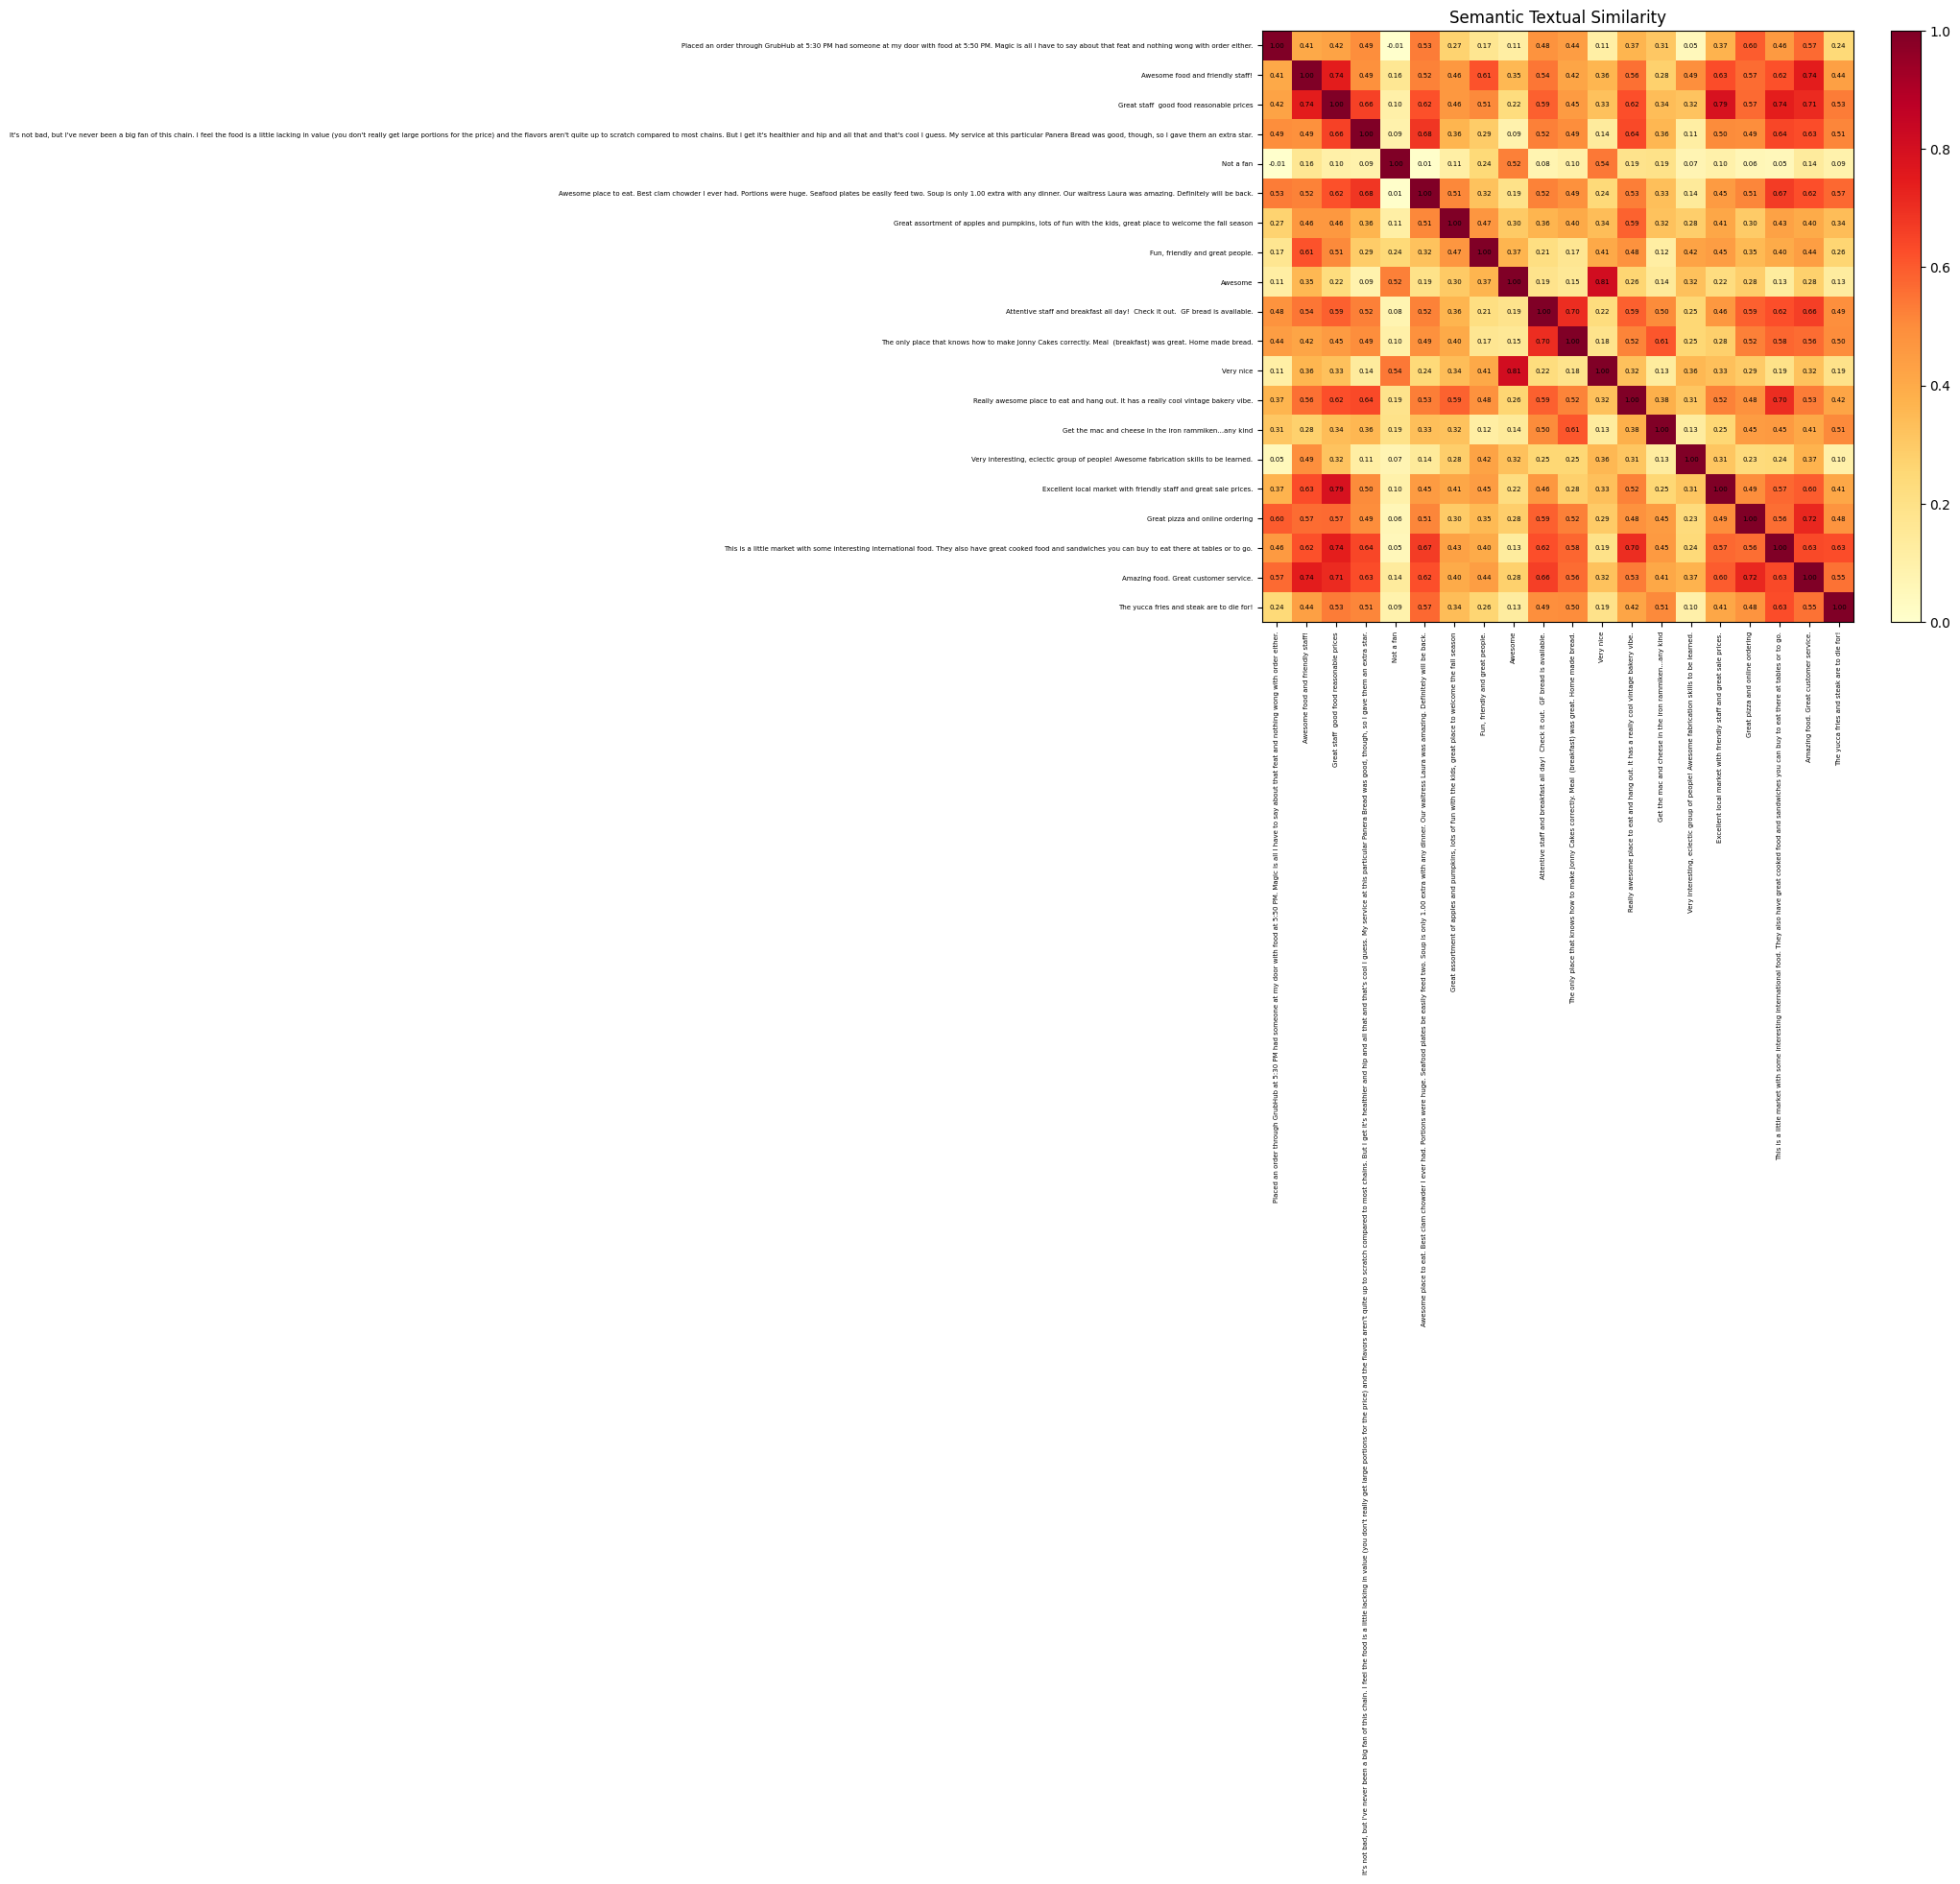

In [35]:
%%local

def plot_similarity(similarity_matrix, df):
    text_list = df["text"].tolist()
    similarity_matrix = similarity_matrix

    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(similarity_matrix, cmap="YlOrRd", vmin=0, vmax=1)

    # Show all ticks and label them with the respective text
    ax.set_xticks(range(len(text_list)))
    ax.set_yticks(range(len(text_list)))
    ax.set_xticklabels(text_list, rotation=90, fontsize=5)
    ax.set_yticklabels(text_list, fontsize=5)

    # Set the annotations with two decimal places
    for i in range(len(text_list)):
        for j in range(len(text_list)):
            text = ax.text(j, i, f"{similarity_matrix[i, j]:.2f}",
                           ha="center", va="center", color="black", fontsize=5)

    # Set title and colorbar
    ax.set_title("Semantic Textual Similarity")
    cbar = ax.figure.colorbar(im, ax=ax)

    # Show the plot
    plt.show()

    
plot_similarity(new_matrix, df2)

In [36]:
df2 = df.limit(500)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
df2.show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------+-------------------------------------+-------------+------+-----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|index|text                

#### BERTopic Overview

BERTopic is an innovative topic modeling approach. This technique enables the extraction of meaningful topics from a collection of documents. Topic modeling serves as a useful method for discovering latent themes within textual data, facilitating efficient organization and comprehension of large volumes of text.

By leveraging BERT's contextual word embeddings, BERTopic captures the semantic essence of words within each document. It generates document representations by aggregating these embeddings using UMAP (Uniform Manifold Approximation and Projection), a dimensionality reduction technique that transforms high-dimensional word vectors into a lower-dimensional space.

Through hierarchical clustering, BERTopic groups similar documents together, forming distinct clusters that represent different topics. To highlight the most relevant keywords for each cluster, BERTopic employs c-TF-IDF (class-based Term Frequency-Inverse Document Frequency), a technique that assigns importance scores to words.

BERTopic offers efficient handling of large datasets by utilizing approximate nearest neighbors algorithms, allowing for speedy topic modeling on extensive text collections.

With its user-friendly API and diverse functionalities such as topic visualization, topic labeling, and topic reduction, BERTopic empowers users to explore and analyze their document collections thoroughly.

BERTopic allows you to defined your embedding model, dimension reduction model and the clustering model.

In this portion the models are defined in the BERTopic model and is used to visualise the topics from the corpus. HTML files of the visualisations are then written to the PV.


#### Models used for BERTopic
For the Bertopic the following models were used:
<br>
- embedding model: distil-bert-cased

DistilBERT is a model that uses distillation during the pretraining phase. The model is able to reduce the size by 40% as compared to the conventional BERT and retains 97% of the language understanding capabilities. Speed wise it is also 60 % faster. For more details you can refer to [this](https://arxiv.org/pdf/1910.01108.pdf).

<br>

- Dimensional Reduction: UMAP (Uniform Manifold Approximation and Projection)

UMAP is a powerful tool for dimensionality reduction, which is the process of reducing the number of features in a dataset while preserving as much of the original information as possible.
In essence, UMAP works by constructing a low-dimensional representation of the data based on its underlying manifold structure. The manifold structure is essentially the geometric shape that the data forms in high-dimensional space, and UMAP uses a graph-based approach to approximate this structure in lower dimensions.

To achieve this, UMAP first constructs a weighted graph representation of the data, where the vertices of the graph represent the individual data points and the edges represent the pairwise distances between them. UMAP then uses a fuzzy set theory to construct a fuzzy topological representation of the data, which captures the relationship between the data points and the manifold structure they form.

UMAP then projects the fuzzy topological representation of the data onto a lower-dimensional space, while preserving the local structure of the data as much as possible. This results in a compressed representation of the data that can be visualized and analyzed in lower dimensions.

For more information, please refer to [this](https://arxiv.org/pdf/1802.03426.pdf).

<br>

- clustering: HDBSCAN

HDBSCAN is a powerful clustering algorithm that takes into account the density of points in a dataset to create a hierarchy of clusters. It starts by considering each data point as a separate cluster and then merges them based on their similarity, using a measure called mutual reachability distance that takes into account the density of points between them.

This approach allows for the detection of clusters at different scales, ranging from large and sparse to small and dense ones. Moreover, the algorithm is capable of identifying outliers, which are points that do not belong to any cluster.

One of the main advantages of HDBSCAN is its ability to handle complex datasets, such as those with non-uniform densities or clusters of varying shapes and sizes. Additionally, it is an efficient and scalable algorithm, making it suitable for large datasets.

Please refer to this [notebook](https://nbviewer.org/github/scikit-learn-contrib/hdbscan/blob/master/notebooks/How%20HDBSCAN%20Works.ipynb) to understand how HDBSCAN works.

<br>

#### Implementation

In [38]:
# split the text column to create a new DataFrame with the words
words_df = df2.select("preprocessed_text").alias("words")

# create a list of all the words
corpus_bt = [word for row in words_df.rdd.map(lambda x: x[0]).collect() for word in row]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
embedding_model = pipeline("feature-extraction", model="distilbert-base-cased")

umap_model = UMAP(n_neighbors=3, n_components=5, min_dist=0.0, metric='cosine')

cluster_model = HDBSCAN(min_cluster_size = 15, 
                        metric = 'euclidean', 
                        cluster_selection_method = 'eom', 
                        prediction_data = True)

# BERTopic model
topic_model = BERTopic(embedding_model = embedding_model,
                       umap_model=umap_model,
                       hdbscan_model = cluster_model)

# Fit the model on a corpus
topics, probs = topic_model.fit_transform(corpus_bt)


# Save intertopic distance map as HTML file
topic_model.visualize_topics().write_html("/opt/spark/work-dir/intertopic_dist_map.html")

# Save topic-terms barcharts as HTML file
topic_model.visualize_barchart(top_n_topics = 10).write_html("/opt/spark/work-dir/barchart.html")

# Save documents projection as HTML file
topic_model.visualize_documents(corpus_bt).write_html("/opt/spark/work-dir/projections.html")

# Save topics dendrogram as HTML file
topic_model.visualize_hierarchy().write_html("/opt/spark/work-dir/hieararchy.html")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Transferring to Local Context
Then, the HTML is ported as a spark.sql dataframe to the local context as a pandas dataframe.

In [ ]:
%%spark -o idm
with open("/opt/spark/work-dir/intertopic_dist_map.html", 'r') as file:

    text = str(file.read())

    # Define the schema
    schema = StructType([
        StructField("File", StringType(), nullable=False)
    ])

    # Create a DataFrame
    idm = spark.createDataFrame([(text,)], schema)

    # Output the DataFrame
    idm.show()

#### HTML in working directory
The HTML is then saved in the working directory which can be downloaded.The HTML files will be rendered after using your browser to open it.
![picture](img/picture18.png)

In [ ]:
%%local

# Extract the column values as a NumPy array
file_column = idm["File"].values

# Convert the NumPy array to a string
content_string = "\n".join(file_column)

# Save the content string to a file
file_path = "/home/jovyan/work/intertopic_dist_map.html"
with open(file_path, "w") as file:
    file.write(content_string)


In [ ]:
%%spark -o bc
with open("/opt/spark/work-dir/barchart.html", 'r') as file:

    text = str(file.read())

    # Define the schema
    schema = StructType([
        StructField("File", StringType(), nullable=False)
    ])

    # Create a DataFrame
    bc = spark.createDataFrame([(text,)], schema)

    # Output the DataFrame
    bc.show()

In [ ]:
%%local

# Extract the column values as a NumPy array
file_column = bc["File"].values

# Convert the NumPy array to a string
content_string = "\n".join(file_column)

# Save the content string to a file
file_path = "/home/jovyan/work/barchart.html"
with open(file_path, "w") as file:
    file.write(content_string)

In [ ]:
%%spark -o pp
with open("/opt/spark/work-dir/projections.html", 'r') as file:

    text = str(file.read())

    # Define the schema
    schema = StructType([
        StructField("File", StringType(), nullable=False)
    ])

    # Create a DataFrame
    pp = spark.createDataFrame([(text,)], schema)

    # Output the DataFrame
    pp.show()

In [ ]:
%%local

# Extract the column values as a NumPy array
file_column = pp["File"].values

# Convert the NumPy array to a string
content_string = "\n".join(file_column)

# Save the content string to a file
file_path = "/home/jovyan/work/projections.html"
with open(file_path, "w") as file:
    file.write(content_string)

In [ ]:
%%spark -o hh
with open("/opt/spark/work-dir/hieararchy.html", 'r') as file:

    text = str(file.read())

    # Define the schema
    schema = StructType([
        StructField("File", StringType(), nullable=False)
    ])

    # Create a DataFrame
    hh = spark.createDataFrame([(text,)], schema)

    # Output the DataFrame
    hh.show()

In [ ]:
%%local

# Extract the column values as a NumPy array
file_column = hh["File"].values

# Convert the NumPy array to a string
content_string = "\n".join(file_column)

# Save the content string to a file
file_path = "/home/jovyan/work/hieararchy.html"
with open(file_path, "w") as file:
    file.write(content_string)